## Set Up

In [1]:
import os
import time
from dataclasses import dataclass
from functools import reduce
from operator import mul
from typing import Any, Optional, Union
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import wandb
import tests.part1_toy_model_tests

torch_device = 'cuda' if t.cuda.is_available() else "cpu" # mps not supported 

## Helper Functions

In [2]:
def plot_images(imgs: t.Tensor, titles: Optional[list[str]] = None) -> None:
    n_images = imgs.shape[0]
    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
    
    # Convert axes to array if there's only one image
    if n_images == 1:
        axes = [axes]
    
    for i in range(n_images):
        img = rearrange(imgs[i], "c h w -> h w c")
        axes[i].imshow(img.numpy())
        if titles and i < len(titles):
            axes[i].set_title(titles[i])
        axes[i].axis('off')  # This removes the axes for cleaner visualization
    
    plt.tight_layout()  # Adjusts spacing between subplots
    plt.show()

def log_images(
    img: t.Tensor,
    noised: t.Tensor,
    noise: t.Tensor,
    noise_pred: t.Tensor,
    reconstructed: t.Tensor,
    num_images: int = 3,
) -> list[wandb.Image]:
    """
    Convert tensors to wandb images for logging.
    Returns an image with the ground truth in the upper row, and model reconstruction on the bottom row. 
    Left is the noised image, middle is noise, and reconstructed image is in the rightmost column.
    """
    actual = t.cat((noised, noise, img), dim=-1)
    pred = t.cat((noised, noise_pred, reconstructed), dim=-1)
    log_img = t.cat((actual, pred), dim=-2)
    images = [wandb.Image(i) for i in log_img[:num_images]]
    return images

## Introduction

<img src="references/paper_background.png" alt="Paper Background">
<figcaption><code>Section 2: Background</code> in <a href="https://arxiv.org/pdf/2006.11239#page=2">Denoising Diffusion Probabilistic Models</a></figcaption>

### Equation 1: Reverse Process
$p$ is a **probability density function** that represents the **reverse** process, the process of adding noise. 

Let's start with the notation $p(x_T) = N(x_T; 0, I)$. $N$ is a normal distribution. $0$ is the mean (centered at zero). $I$ is the identity matrix representing the covariance (meaning that elements are independent with unit variance). It describes the distribution of completely random noise, which is the starting point $x_T$.

With that information, we can understand Equation 1. $p_\theta(X_{0:T})$ represents starting with $p(x_T)$ (a standard normal distribution) and continually multiplying other normals distibutions that have the same dimensionality. You can think of it like a blob of proabiltiies iteratively shifting around, approaching the de-noised output. 

To implement this in our code, we will be **sampling**. We will start with a sample from $p_(x_T)$ (a standard normal distribution). Next, we will pass the sample into our model to get the mean and variance terms, and use those terms with define a new Guassian to obtain a new sample $p(x_{t-1})$. We can keep repeating this process until we reach $p(x_0)$, which should look like a real $x_0$. 

### Equation 2: Forward/Diffusion Process

$q$ is a a **probability density** function that represents the **forward** or **diffusion** process, the process of adding noise. We apply noise in small steps T, where each $\beta_t$ is a scalar that controls the variance of the normal distribution. Since we take the square root of 1 - $\beta_t$, every $\beta_t$ will less than or equal to 1. We implement the variance schedule $\beta_t$ in [Variance Schedule](##variance-schedule).

Just like the **reverse** process, the forward process is also a product of Gaussian/normal distributions. Note that every Gaussian is independent of each other. To calculate the distribution $q(x_t)$, we only need $x_{t-1}$ and the $\beta_t$ value corresponding to the step number. All pixels and color channels are noised independently. 

## Creating dataset

We'll first generate a dataset of random color gradients for our toy model. We will train the model to be able to recover these gradients from random images by the end of this notebook. Each of these generated images will represents our $x_0$.This should be an easy task for neural networks since the structure of the data is simple.

<details>
<summary>What is a color gradient?</summary>

Color gradients displays the range of possible combinations of **two** colors, with each of the **two** colors on opposite corners.

</details>

In [3]:
def gradient_images(n_images: int, img_size: tuple[int, int, int]) -> t.Tensor:
    """
    Generate n_images of img_size, each being a color gradient.
    
    Args:
        n_images: Number of gradient images to generate
        img_size: Tuple of (channels, height, width)
    
    Returns:
        Tensor of shape (n_images, channels, height, width) containing normalized gradients
    """
    C, H, W = img_size
    
    # Keep corners as integers (0-255) like the original
    corners = t.randint(0, 255, (2, n_images, C), dtype=t.float32)
    
    # Create coordinate grids
    x_coords = t.linspace(0, W / (W + H), W)
    y_coords = t.linspace(0, H / (W + H), H)
    x, y = t.meshgrid(x_coords, y_coords, indexing="xy")
    
    # Use grid[-1, -1] for normalization exactly as original
    grid = x + y
    grid = grid / grid[-1, -1]
    
    # Expand dimensions for broadcasting
    grid = grid.unsqueeze(0).unsqueeze(0)  # shape: 1, 1, H, W
    grid = grid.expand(n_images, C, H, W)   # shape: n_images, C, H, W
    
    # Calculate gradients using broadcasting but keeping original value ranges
    start_colors = corners[0].unsqueeze(-1).unsqueeze(-1)  # shape: n_images, C, 1, 1
    color_ranges = (corners[1] - corners[0]).unsqueeze(-1).unsqueeze(-1)
    
    # Combine everything and normalize at the end like original
    gradients = start_colors + grid * color_ranges
    gradients = gradients / 255
    
    assert gradients.shape == (n_images, C, H, W)
    
    return gradients

A few samples from the input distribution: 


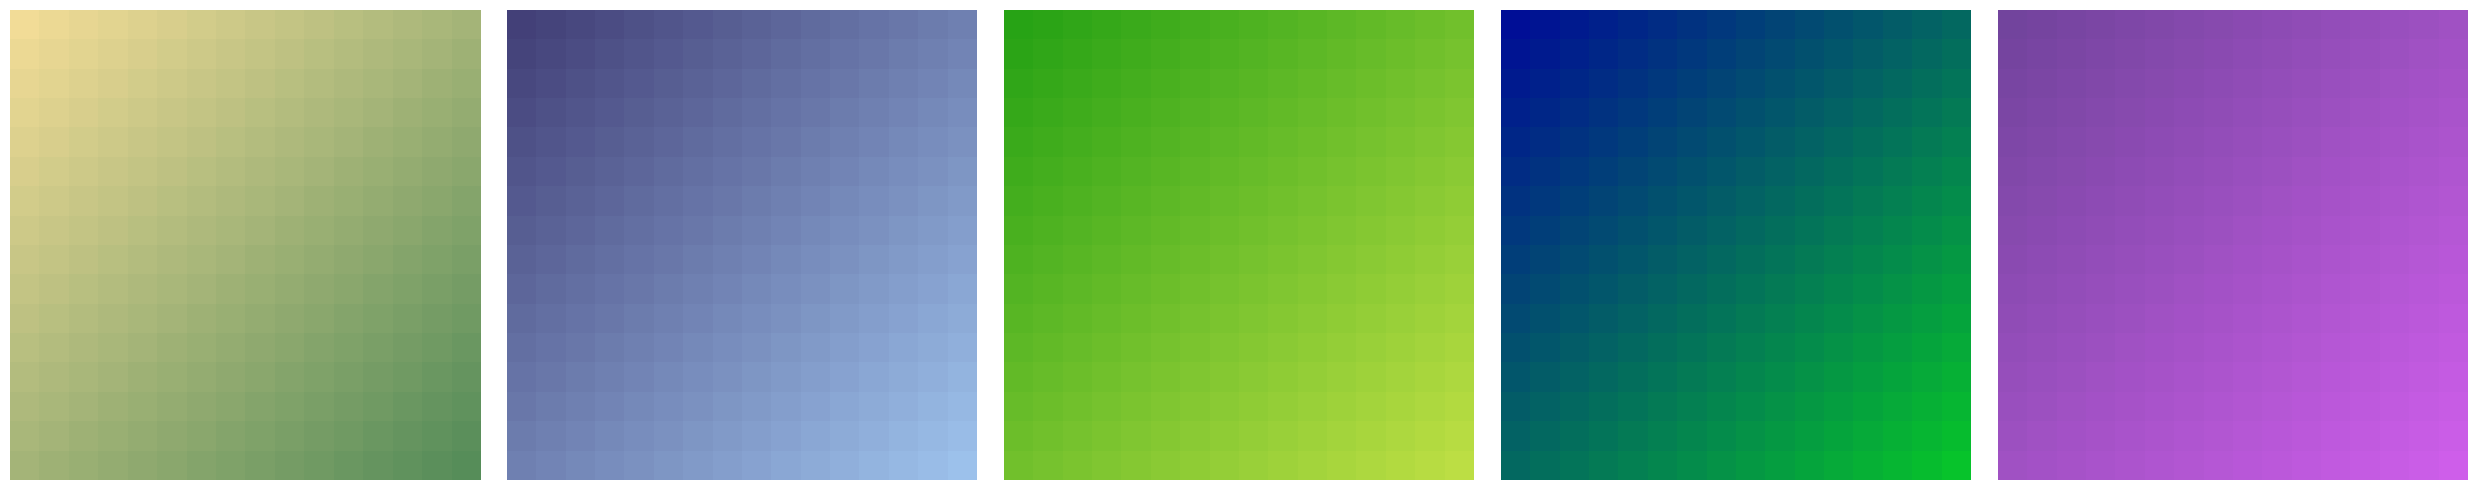

In [4]:
print("A few samples from the input distribution: ")
img_shape = (3, 16, 16)
n_images = 5
imgs = gradient_images(n_images, img_shape)
plot_images(imgs) # Try running a few times until you understand color gradients

## Normalization

For every image, every $(\text{channel} \times \text{height} \times \text{weight})$ has a value between $[0, 1]$, but to help neural networks to learn if we preprocess the data to have a mean of 0. This helps with faster and more stable training, provides better conditions for optimization problems, and reduces the impact of initialization.

All of our model's inputs will be normalized, but we will denormalize output whenever we want to visualize the results.


In [5]:
def normalize_img(img: t.Tensor) -> t.Tensor:
    return img * 2 - 1


def denormalize_img(img: t.Tensor) -> t.Tensor:
    return ((img + 1) / 2).clamp(0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32549018..0.8980392].


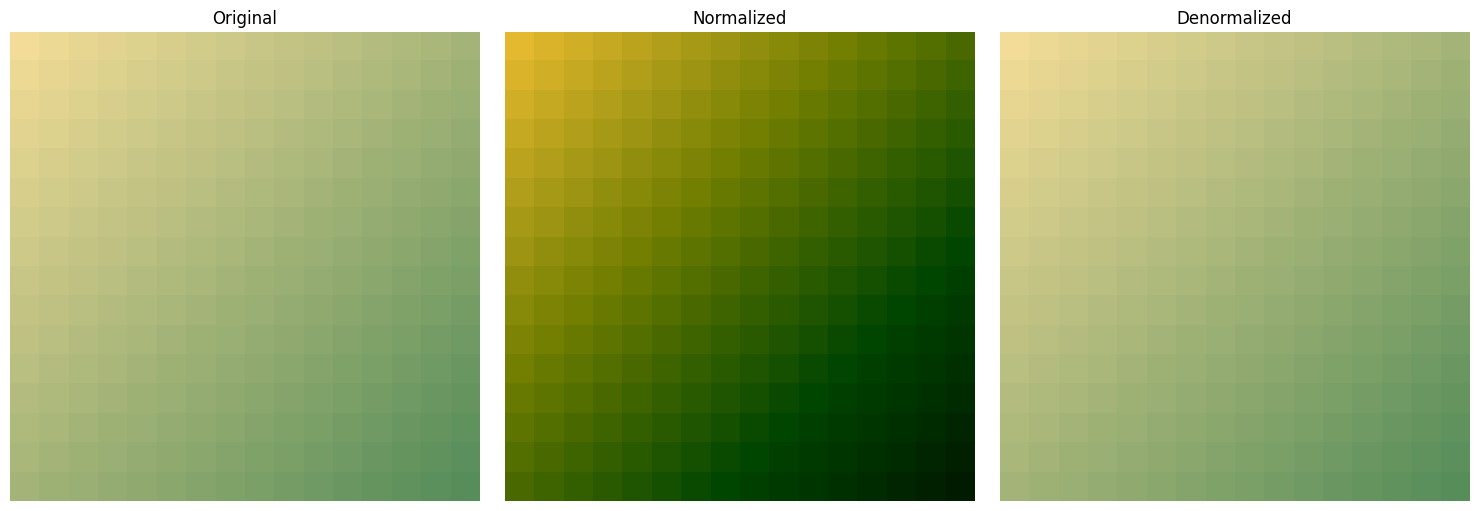

In [6]:
# Normalize/Denormalize the first image from the above section
plot_images(t.stack([imgs[0], normalize_img(imgs)[0], denormalize_img(normalize_img(imgs))[0]]), ["Original", "Normalized", "Denormalized"])

## Variance schedule


<img src="references/variance_schedule.png" alt="Descriptive alt text">
<figcaption><code>Section 4: Experiments</code> in <a href="https://arxiv.org/pdf/2006.11239#page=5">Denoising Diffusion Probabilistic Models</a></figcaption>


In the paper, the authors linearly scaled the amount of noise, $\beta$, from $10^{-4}$ to $0.02$ in 1000 steps. Since we are training a smaller and simpler dataset, we are going to only be using **200 steps** in this notebook for faster training.

In [7]:
def variance_schedule(max_steps: int, min_noise: float = 0.0001, max_noise: float = 0.02) -> t.Tensor:
    """Return the forward process variances as in the paper.

    max_steps: total number of steps of noise addition
    out: shape (step=max_steps, ) the amount of noise at each step
    """
    return t.linspace(min_noise, max_noise, max_steps)

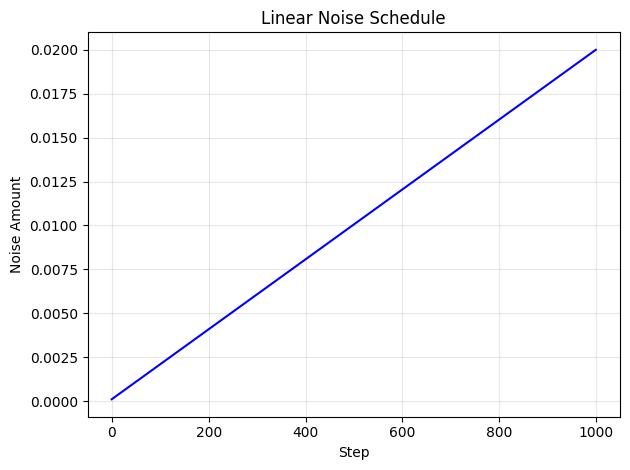

tests.part1_toy_model_tests.test_variance_schedule passed in 0.00s.


In [8]:
steps = 1000
betas = variance_schedule(steps)

plt.figure()
plt.plot(range(steps), betas, 'b-', label='Noise Schedule')
plt.title('Linear Noise Schedule')
plt.xlabel('Step')
plt.ylabel('Noise Amount')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

tests.part1_toy_model_tests.test_variance_schedule(variance_schedule) # simple check for a linear function

## Forward (q) function

### Forward (q) function: Equation 2

<img src="references/forward_equation.png" alt="Forward Equation">
<figcaption><code>Section 2: Background - Equation 2</code> in <a href="https://arxiv.org/pdf/2006.11239#page=2">Denoising Diffusion Probabilistic Models</a></figcaption>


Compute the **forward** function. This function iteratively samples from a normal distribution of the (1) a weighted mean of $x_{t-1}$ and (2) a scheduled varaiance. In early steps $t$, $x_{t-1}$ is heavily waited in the mean and the variance is low. But in later steps $t$, the mean approaches 0 and standard deviation appraches 1. 

Remeber that our input is normalized with a mean of 0 and $\beta$ range from $10^{-4}$ to $0.02$

In [9]:
def q_eq2(x: t.Tensor, num_steps: int, betas: t.Tensor) -> t.Tensor:
    """
    Add noise to the input image iteratively using a noise schedule.

    Args:
        x: Input image tensor of shape (channels, height, width)
        num_steps: Number of noise iterations to perform
        betas: Noise schedule tensor of shape (T,) containing variance values,
              where T >= num_steps

    Returns:
        Noised image tensor of shape (channels, height, width)
    """
    for beta in betas[:num_steps]:
        x = t.normal(t.sqrt(1 - beta) * x, t.sqrt(beta))
        # OR
        # x = t.sqrt(1 - beta) * x + t.randn_like(x) * t.sqrt(beta)
    return x

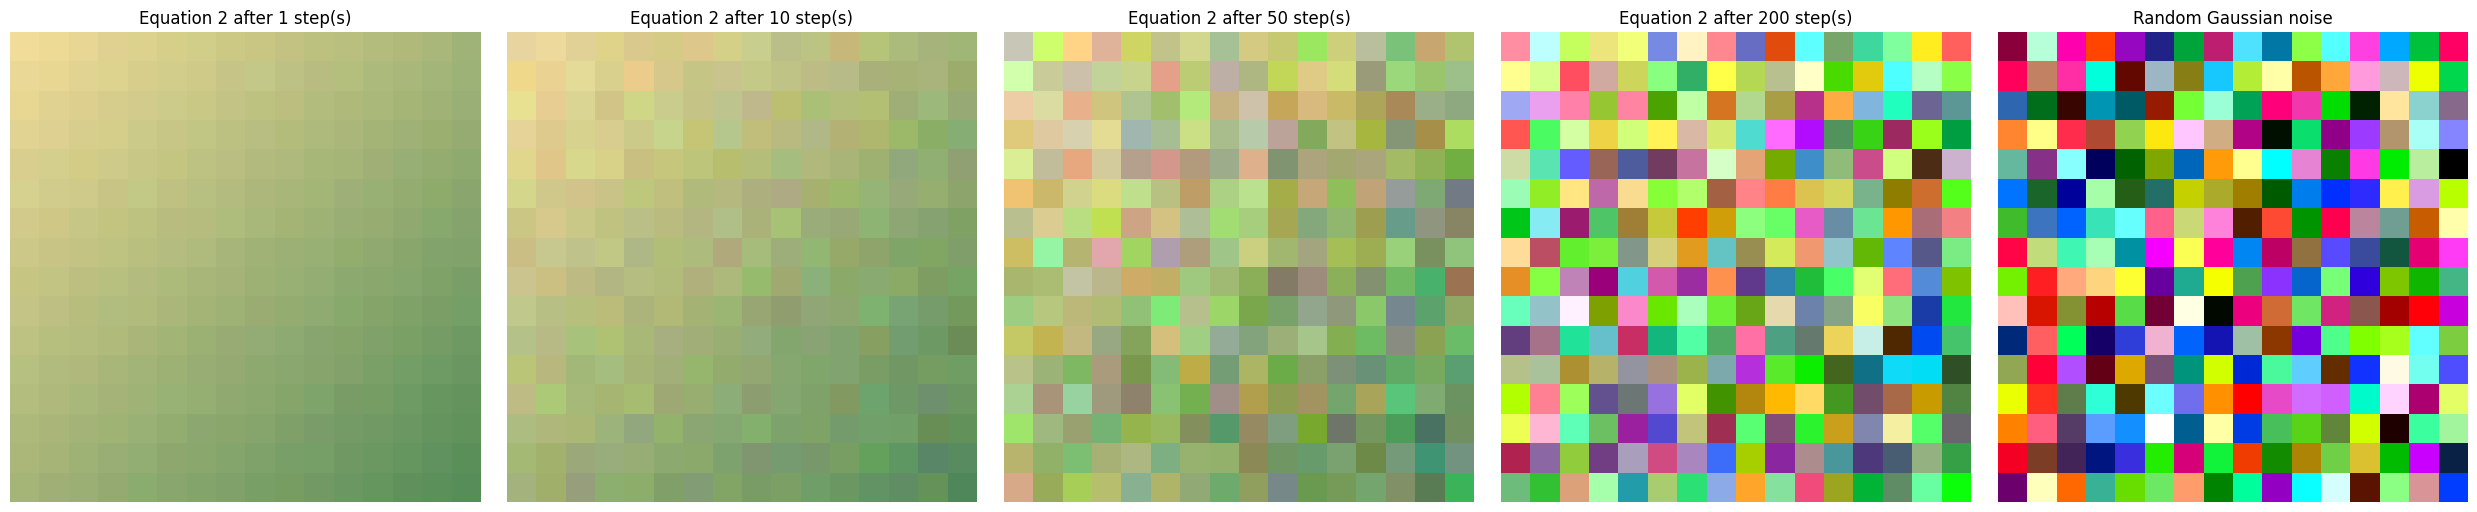

tests.part1_toy_model_tests.test_q_eq2 passed in 0.38s.


In [10]:
x = normalize_img(imgs[0])
# x = normalize_img(gradient_images(1, (3, 16, 16))[0]) # Try with new random gradient

q_x = []
titles = []
for num_steps in [1, 10, 50, 200]:
    xt = q_eq2(x, num_steps, betas)
    q_x.append(denormalize_img(xt))
    titles.append(f"Equation 2 after {num_steps} step(s)")

q_x.append(denormalize_img(t.randn_like(xt)))
titles.append("Random Gaussian noise")

plot_images(t.stack(q_x), titles)
tests.part1_toy_model_tests.test_q_eq2(q_eq2, variance_schedule, x) # check after lots of steps, the image is close to a standard Gaussian

After 50 steps, we can barely make out the colors of the original gradient. After 200 steps, the image looks like random Gaussian noise. As we go from left to right, we start a high signal with most of the image strucutre preserved, but as well continue taking steps, we go from noisy image to pure noise.

### Forward (q) function: Equation 4

<img src="references/forward_equation2.png" alt="Forward Equation 2">
<figcaption><code>Section 2: Background - Equation 4</code> in <a href="https://arxiv.org/pdf/2006.11239#page=2">Denoising Diffusion Probabilistic Models</a></figcaption>

Equation 2 shows the **forward** process with a "for loop" that iteratively samples from a Guassian distribution with a weighted mean of the previous image. However, using a "for loop" is computationally expensive. 

Equation 4 optimizes Equation 2 by calculating $\alpha$, a closed form notation to directly go to step $t$. The ouputs of Equation 4 should look almost identical to Equation 2. 

In [11]:
def q_eq4(x: t.Tensor, num_steps: int, betas: t.Tensor) -> t.Tensor:
    """Equivalent to Equation 2 but without a for loop."""
    alphas = 1.0 - betas
    alpha_bar = t.prod(alphas[:num_steps])
    noise = t.randn_like(x)
    return t.sqrt(alpha_bar) * x + t.sqrt(1 - alpha_bar) * noise

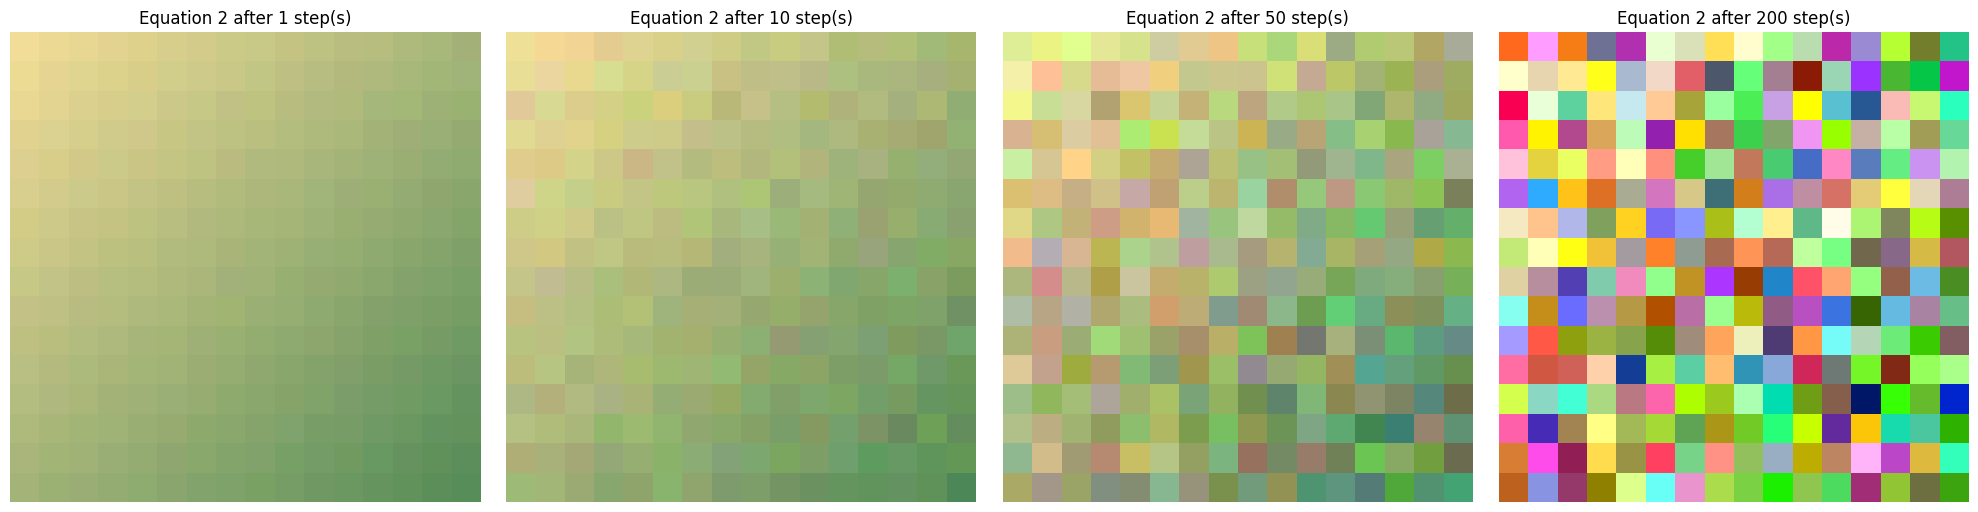

tests.part1_toy_model_tests.test_q_eq4 passed in 0.00s.


In [12]:
q_x = []
titles = []
for num_steps in [1, 10, 50, 200]:
    xt = q_eq4(x, num_steps, betas)
    q_x.append(denormalize_img(xt))
    titles.append(f"Equation 2 after {num_steps} step(s)")

plot_images(t.stack(q_x), titles)
tests.part1_toy_model_tests.test_q_eq4(q_eq4, variance_schedule, x) # check after lots of steps, the image is close to a standard Gaussian

## Noise Schedule

We will need to remember the noise schedule we used during training (forward equation) for in our reconstruction process. This `NoiseSchedule` class (`nn.Module` subclass) will help us pre-compute and store our $\beta$, $\alpha$, and $\bar{\alpha}$ values to use during training and sampling.



In [13]:
class NoiseSchedule(nn.Module):
    betas: t.Tensor
    alphas: t.Tensor
    alpha_bars: t.Tensor

    def __init__(
        self, max_steps: int, device: Union[t.device, str], min_noise: float = 0.0001, max_noise: float = 0.02
    ) -> None:
        super().__init__()
        self.max_steps = max_steps
        self.device = device
        self.register_buffer("betas", variance_schedule(max_steps, min_noise, max_noise))
        alphas = 1 - self.betas
        self.register_buffer("alphas", alphas)
        alpha_bars = t.cumprod(alphas, dim=-1)
        self.register_buffer("alpha_bars", alpha_bars)
        self.to(device)

    @t.inference_mode()
    def beta(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the beta(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.betas[num_steps]

    @t.inference_mode()
    def alpha(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the alphas(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.alphas[num_steps]

    @t.inference_mode()
    def alpha_bar(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the alpha_bar(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.alpha_bars[num_steps]

    def __len__(self) -> int:
        return self.max_steps

Next, let's use a batched version of our optimized forward (q) function and our new `NoiseSchedule` to generate batches of noised images.

In [14]:
def noise_img(
    img: t.Tensor, noise_schedule: NoiseSchedule, max_steps: Optional[int] = None
) -> tuple[t.Tensor, t.Tensor, t.Tensor]:
    """
    Adds a random number of steps of noise to each image in img.

    img: An image tensor of shape (B, C, H, W)
    noise_schedule: The NoiseSchedule to follow
    max_steps: if provided, only perform the first max_steps of the schedule

    Returns a tuple composed of:
    num_steps: an int tensor of shape (B,) of the number of steps of noise added to each image
    noise: the unscaled, standard Gaussian noise added to each image, a tensor of shape (B, C, H, W)
    noised: the final noised image, a tensor of shape (B, C, H, W)
    """
    (B, C, H, W) = img.shape
    if max_steps is None:
        max_steps = len(noise_schedule)
    assert len(noise_schedule) >= max_steps
    num_steps = t.randint(1, max_steps, size=(B,), device=img.device)
    noise = t.randn_like(img)
    x_scale = noise_schedule.alpha_bar(num_steps).sqrt()
    noise_scale = (1 - noise_schedule.alpha_bar(num_steps)).sqrt()
    noised = (
        repeat(x_scale, "b -> b c h w", c=C, h=H, w=W) * img
        + repeat(noise_scale, "b -> b c h w", c=C, h=H, w=W) * noise
    )
    assert num_steps.shape == (B,)
    assert noise.shape == (B, C, H, W)
    assert noised.shape == (B, C, H, W)
    return num_steps, noise, noised

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8089468..2.977762].


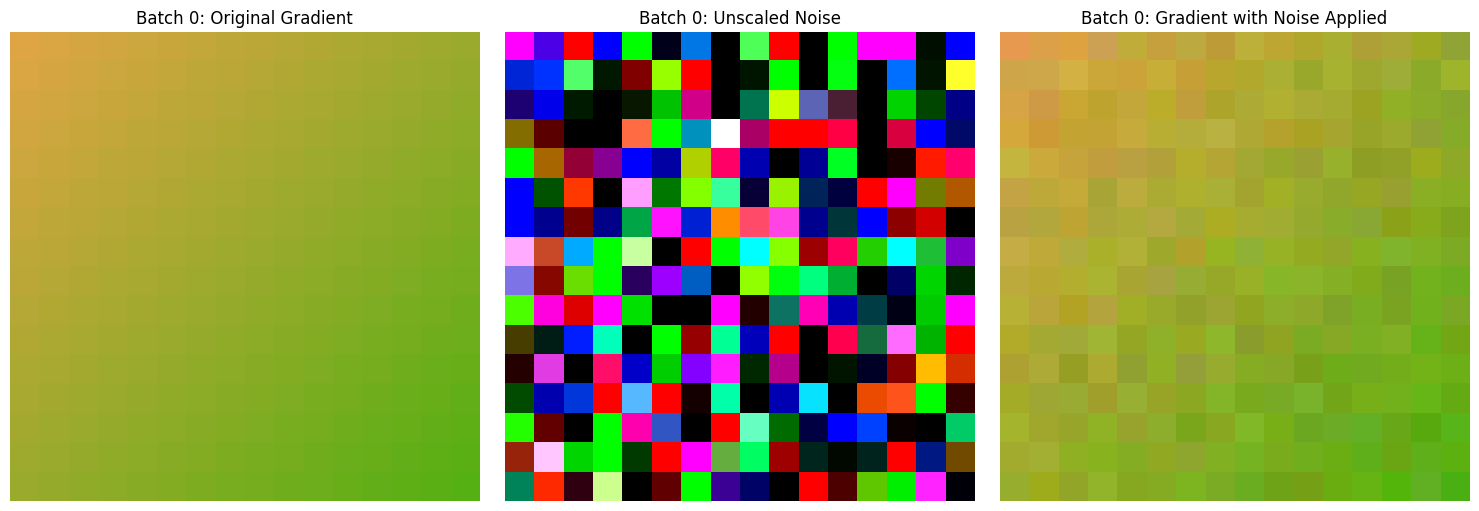

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5457945..2.9006844].


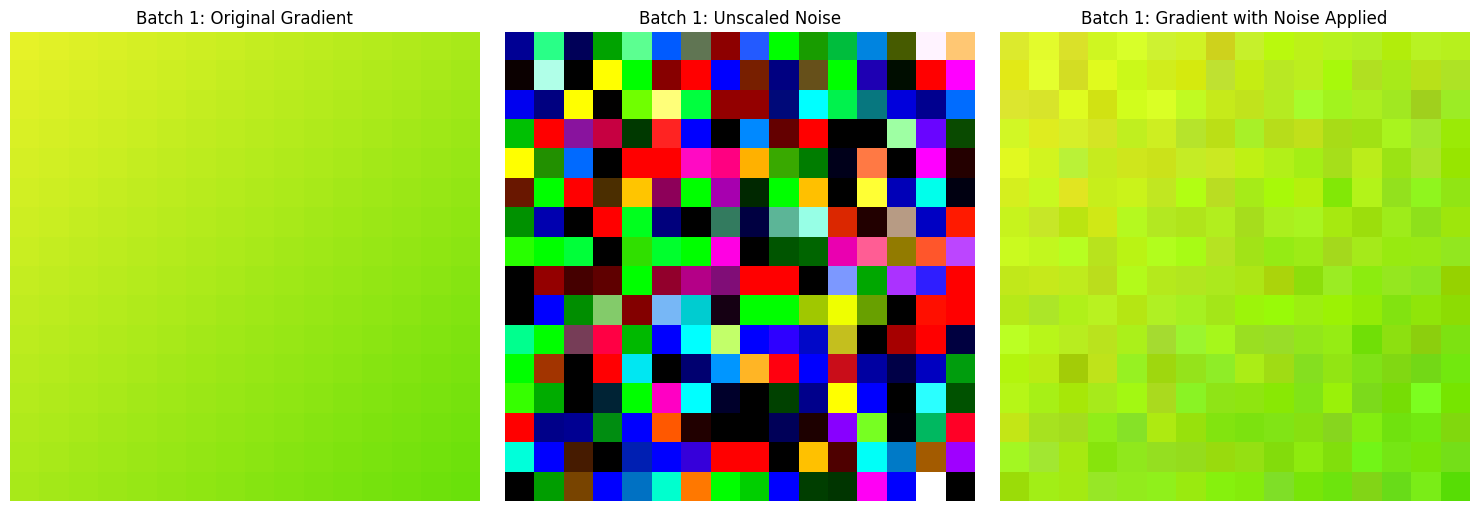

tests.part1_toy_model_tests.test_noise_img passed in 0.11s.


In [18]:
noise_schedule = NoiseSchedule(max_steps=200, device="cpu")
img = gradient_images(2, (3, 16, 16))
(num_steps, noise, noised) = noise_img(normalize_img(img), noise_schedule, max_steps=10)


for i in range(img.shape[0]):
    images = t.stack([img[i], noise[i], denormalize_img(noised[i])])
    titles = [f"Batch {i}: Original Gradient", f"Batch {i}: Unscaled Noise", f"Batch {i}: Gradient with Noise Applied"]
    plot_images(images, titles)    
tests.part1_toy_model_tests.test_noise_img(noise_img, NoiseSchedule, gradient_images, normalize_img) # check after lots of steps, the image is close to a standard Gaussian

## Reconstruct

During training, we will want to reconstruct the image for logging purposes. We will be using the noisy image, the predicted noise, and the noise schedule to try to reconstruct to original image so we can visually see how close the prediction is. 

This is the inverse function of the `noise_img()` function above.

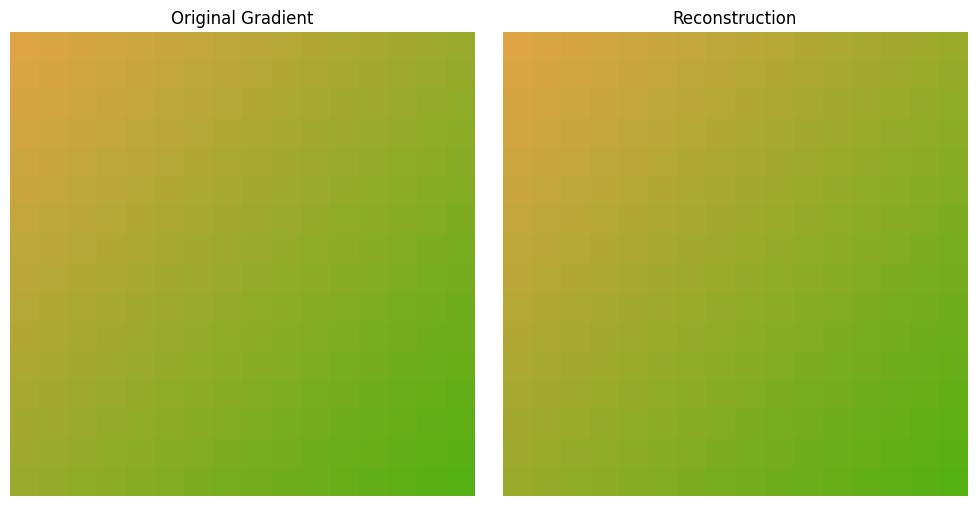

tests.part1_toy_model_tests.test_reconstruct passed in 0.00s.


In [19]:
def reconstruct(
    noisy_img: t.Tensor,
    noise: t.Tensor,
    num_steps: t.Tensor,
    noise_schedule: NoiseSchedule,
) -> t.Tensor:
    """
    Subtract the scaled noise from noisy_img to recover the original image. We'll later use this with the model's output to log reconstructions during training. We'll use a different method to sample images once the model is trained.

    Returns img, a tensor with shape (B, C, H, W)
    """
    B, C, H, W = noisy_img.shape
    x_scale = noise_schedule.alpha_bar(num_steps).sqrt()
    noise_scale = (1 - noise_schedule.alpha_bar(num_steps)).sqrt()
    img = noisy_img - repeat(noise_scale, "b -> b c h w", c=C, h=H, w=W) * noise
    img = img / repeat(x_scale, "b -> b c h w", c=C, h=H, w=W)
    assert img.shape == (B, C, H, W)
    return img


reconstructed = reconstruct(noised, noise, num_steps, noise_schedule)
denorm = denormalize_img(reconstructed)
plot_images(t.stack([img[0], denorm[0]]), ["Original Gradient", "Reconstruction"])
tests.part1_toy_model_tests.test_reconstruct(denorm, img) # check that reconstruction matches the original

## Toy Diffusion Model Definition

For our model architecture, we will be using a simple two-layer MLP.

The algorithm for the forward pass is:
1. Scale down the the number of steps to between [0, 1]
2. Convert the images into a 1D vector of length $k = (\text{channel} \times \text{height} \times \text{weight})$ to a $(batch, k)$ vector
3. Concatenate the image vectors and the "number of step" vectors to a $(batch, k+1)$ vector
4. Apply to a $(k+1, d_model)$ linear transformation to a $(batch, d_{model})$ vector
5. Take the Relu actvations 
6. Apply a final $(d_{model}, k)$ linear transormation to a $(batch, k)$ vector
7. Reshape the $(batch, k)$ back into the images dimensions $(batch, channel, height, width)$ representing the prediction of the noise that was added to the original image.

In [20]:
@dataclass(frozen=True)
class ToyDiffuserConfig:
    img_shape: tuple[int, ...]
    d_model: int
    max_steps: int


class ToyDiffuser(nn.Module):
    config: ToyDiffuserConfig
    img_shape: tuple[int, ...]
    noise_schedule: Optional[NoiseSchedule]
    max_steps: int
    model: nn.Sequential

    def __init__(self, config: ToyDiffuserConfig):
        """
        A toy diffusion model composed of an MLP (Linear, ReLU, Linear).
        """
        super().__init__()
        self.config = config
        self.img_shape = config.img_shape
        self.noise_schedule = None 
        self.max_steps = config.max_steps
        
        assert len(config.img_shape) == 3
        num_pixels = int(reduce(mul, config.img_shape))
        self.model = nn.Sequential(
            nn.Linear(num_pixels + 1, config.d_model),
            nn.ReLU(),
            nn.Linear(config.d_model, num_pixels),
            Rearrange(
                "b (c h w) -> b c h w",
                c=config.img_shape[0],
                h=config.img_shape[1],
                w=config.img_shape[2],
            ),
        )

    def forward(self, images: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        """
        Given a batch of images and noise steps applied, attempt to predict the noise that was applied.
        images: tensor of shape (B, C, H, W)
        num_steps: tensor of shape (B,)

        Returns
        noise_pred: tensor of shape (B, C, H, W)
        """
        
        B, C, H, W = images.shape
        assert num_steps.shape == (B,)
        num_steps = num_steps / self.max_steps # Scaling down num_steps to have the range [0, 1]
        model_in = t.cat(
            (
                rearrange(num_steps, "(b 1) -> b 1"),
                rearrange(images, "b c h w -> b (c h w)"),
            ),
            dim=-1,
        )

        out = self.model(model_in)
        assert out.shape == (B, C, H, W)
        return out


Now, let's see the noise preduction of our diffusion model without training. It should just be completely random.

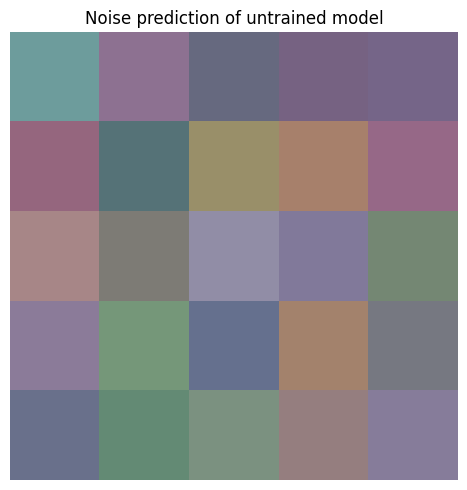

tests.part1_toy_model_tests.test_toy_diffuser passed in 0.00s.


In [21]:
img_shape = (3, 5, 5)
n_images = 5

imgs = gradient_images(n_images, img_shape)
n_steps = t.zeros(imgs.size(0))
model_config = ToyDiffuserConfig(img_shape, 16, 100)
model = ToyDiffuser(model_config)
out = model(imgs, n_steps)

plot_images(denormalize_img(out[0]).detach().unsqueeze(0), ["Noise prediction of untrained model"])
tests.part1_toy_model_tests.test_toy_diffuser(ToyDiffuser, ToyDiffuserConfig) # check that the sizes match what is expected

## Training

<img src="references/training.png" alt="Training">
<figcaption><code>Algorithm 1</code> in <a href="https://arxiv.org/pdf/2006.11239#page=4">Denoising Diffusion Probabilistic Models</a></figcaption>

Line 2 - The $x_0$ is the original training data distrbution, 

Line 3 - We need to draw the number of steps of noise to add for each element of the batch, so the $t$ will have shape $(batch,)$ and be an integer tensor. Both 1 and T are inclusive. Each elemenet gets a different numer of steps of noise added.

Line 4 - $\epsilon$ is a sample noise, not sclaed by anything. It's going to add to the image, so its shape should also be $(batch, channel, height, width)$.

Line 5 - $\epsilon_\theta$ is our neural network. It takes in two arguments: the image with the noise applied in one step of $(batch, channel ,height, width)$, and the number of steps $(batch,)$, normalized to the range $[0,1]$

Line 6 - It is not specified how we know if the network is convered so we are just going to keep going until the loss seems to stop decreasing. 

<img src="references/variational_bound_loss.png" alt="Variational Bound loss">
<figcaption><code>Equation 3</code> in <a href="https://arxiv.org/pdf/2006.11239#page=4">Denoising Diffusion Probabilistic Models</a></figcaption>

<img src="references/mean_squared_error_loss.png" alt="Mean Squared Error Loss">
<figcaption><code>Equation 14</code> in <a href="https://arxiv.org/pdf/2006.11239#page=5">Denoising Diffusion Probabilistic Models</a></figcaption>

In the paper, the author describes two loss functions: the variation lower bound (Equation 3) or the mean squared error (Equation 14). In our implementation, we will be using the mean squared error (MSE) since it is easier to implement, more stable during training, requires fewer compute resources, and we have only training a simple network. 

In [22]:
def train(
    model: ToyDiffuser,
    config_dict: dict[str, Any],
    trainset: TensorDataset,
    testset: Optional[TensorDataset] = None,
) -> ToyDiffuser:

    wandb.init(project="diffusion_models", config=config_dict, mode="online" if config_dict["enable_wandb"] else "disabled")
    config = wandb.config
    print(f"Training with config: {config}")

    schedule = NoiseSchedule(config.max_steps, config.device)
    model.noise_schedule = schedule

    model.train()
    optimizer = t.optim.Adam(model.parameters(), lr=config.lr)

    train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True)
    if testset is not None:
        test_loader = DataLoader(testset, batch_size=config.batch_size)

    start_time = time.time()
    examples_seen = 0
    for epoch in range(config.epochs):
        # for every img in the training set
        for i, (x,) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}")):
            x = x.to(config.device)
            num_steps, noise, noised = noise_img(x, schedule) # add between 1 to max_step iterations of noise to the image
            y_hat = model(noised, num_steps) # predict the noise added to the noised image
            loss = F.mse_loss(y_hat, noise) # MSE loss between predicted noise and actual noise

            # 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # logging
            info: dict[str, Any] = dict(
                train_loss=loss,
                elapsed=time.time() - start_time,
                y_hat_mean=y_hat.mean(), # mean of the predicted noise
                y_hat_var=y_hat.var(), # variance of the predicted noise
                noised_mean=noised.mean(),  # mean of the noised image
                noised_var=noised.var(), # variance of the noised image
            )
            if (i + 1) % config.img_log_interval == 0:
                reconstructed = reconstruct(noised, y_hat, num_steps, schedule)
                info["images"] = log_images(
                    img=x,
                    noised=noised,
                    noise=noise,
                    noise_pred=y_hat,
                    reconstructed=reconstructed,
                    num_images=config.n_images_to_log,
                )

            examples_seen += len(x)
            wandb.log(info, step=examples_seen)
        if testset is not None:
            # Calculate evaluation loss for current epoch
            losses = []
            for i, (x,) in enumerate(tqdm(test_loader, desc=f"Eval for Epoch {epoch + 1}")):
                x = x.to(config.device)
                num_steps, noise, noised = noise_img(x, schedule)
                with t.inference_mode():
                    y_hat = model(noised, num_steps) # predict the noise added to the noised image
                    loss = F.mse_loss(y_hat, noise) # MSE loss between predicted noise and actual noise
                losses.append(loss.item())

            # logging
            eval_info = dict(eval_loss=sum(losses) / len(losses))
            wandb.log(eval_info, step=examples_seen)

    wandb.finish()
    return model

Now let's train our model!

In [23]:
# wandb config
config: dict[str, Any] = dict(
    lr=1e-3,
    image_shape=(3, 5, 5),
    d_model=128,
    epochs=20,
    max_steps=100,
    batch_size=128,
    img_log_interval=200,
    n_images_to_log=3,
    n_images=50000,
    n_eval_images=1000,
    device=torch_device,
    enable_wandb=True
)

# Generate Training and Test data
images = normalize_img(
    gradient_images(
        config["n_images"],
        config["image_shape"],
    )
)
train_set = TensorDataset(images)
images = normalize_img(
    gradient_images(
        config["n_eval_images"],
        config["image_shape"],
    )
)
test_set = TensorDataset(images)

In [24]:
# Diffuser configs
model_config = ToyDiffuserConfig(config["image_shape"], config["d_model"], config["max_steps"])
model = ToyDiffuser(model_config).to(config["device"])

# Train
model = train(model, config, train_set, test_set)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michaelyliu6 (michaelyliu6-none). Use `wandb login --relogin` to force relogin


Training with config: {'lr': 0.001, 'image_shape': [3, 5, 5], 'd_model': 128, 'epochs': 20, 'max_steps': 100, 'batch_size': 128, 'img_log_interval': 200, 'n_images_to_log': 3, 'n_images': 50000, 'n_eval_images': 1000, 'device': 'cpu', 'enable_wandb': True}


Eval for Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 1743.27it/s]


elapsed,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
eval_loss,█▅▅▃▄▄▃▄▇▃▇▄▅▂▃▃▁▃▁▂
noised_mean,▆▄▃▄▂█▃▆▆▄▅▃▆█▁▅▄▃█▇▇▇▃▁▃▆▅▅▂▅▃▅▇▃▅▅▅▃▆▃
noised_var,▄▆▃▇▃▅▅▄█▇▂▄▄▆▅▃▄▅▃▂▃▂▃▃▅▅▂▄▄▆▁▄▆▃▁▄▃▅▆▃
train_loss,█▂▂▁▁▁▂▁▁▁▂▁▂▁▁▂▂▂▁▁▂▂▂▂▂▁▁▂▁▂▂▁▁▂▂▁▁▁▁▁
y_hat_mean,▅▆▃▆▆▅▂▇▆▆▆▁▆▇█▅▇▁▇▄▂▇▄▄▁▇▅▆▄▅▄▅▅▅▆▅▆▃▅▇
y_hat_var,▁▆▇█▇▇▇▇██▇▇▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇
elapsed,6.96781
eval_loss,0.24246
noised_mean,-0.03139
noised_var,0.39638


https://api.wandb.ai/links/michaelyliu6-none/zm4pnu86

## Sampling

<img src="references/sampling.png" alt="Sampling">
<figcaption><code>Algorithm 2</code> in <a href="https://arxiv.org/pdf/2006.11239#page=4">Denoising Diffusion Probabilistic Models</a></figcaption>

Line 1 - Start with a sample from a standard Gaussian

Line 2 - Iteratively step backwards towards the original image with no noise

Line 3 - Calculate the denoised image 

Line 6 - Return the denoised final image


Ror the early steps (high t), we make big changes since the image is very noisy. At later steps (low t), we make smaller, more precise adjustments as we get closer to the final image. 

Note that in Line 3 we are adding a small amount of noise (scaled by $\beta_t$) to maintains the Markov chain properties. However, the release of [DDIM (Denoiseing Diffusion Implicit Models)](https://arxiv.org/pdf/2010.02502) showed that you could remove random noise term during sampling entirely, making the process determinisitc. This led to faster sampling while maintaining good quality. Most interestingly, because DDIM is deterministic, you can smoothly interpolate between two images in the latent space. The intermediate images maintain semantic meaning (e.g., interpolating between a cat and dog image will show meaningful blends of features)

In [25]:
def sample(model: ToyDiffuser, n_samples: int, return_all_steps: bool = False) -> Union[t.Tensor, list[t.Tensor]]:
    """
    Sample, following Algorithm 2 in the DDPM paper

    model: The trained noise-predictor
    n_samples: The number of samples to generate
    return_all_steps: if true, return a list of the reconstructed tensors generated at each step, rather than just the final reconstructed image tensor.

    out: shape (B, C, H, W), the denoised images
    """
    schedule = model.noise_schedule
    assert schedule is not None
    
    model.eval()

    shape = (n_samples, *model.img_shape)
    B, C, H, W = shape
    x = t.randn(shape, device=schedule.device) # Line 1: initalize a sample from a standard Gaussian

    if return_all_steps:
        all_steps = [(x.cpu().clone())]

    for step in tqdm(reversed(range(0, len(schedule))), total=len(schedule)): # Line 2: iterate over all steps in reverse order
        num_steps = t.full((n_samples,), fill_value=step, device=schedule.device)

        if step > 0: # Line 3: add a random sample of noise from a standard Gaussian (except for the last iteration)
            sigma = schedule.beta(step)
            noise_term = sigma * t.randn_like(x)
        else:
            noise_term = 0

        pred = model(x, num_steps) # predict what the noise add was at $t$

        pred_scale = schedule.beta(step) / ((1 - schedule.alpha_bar(step)).sqrt()) # how much do we scale our preidction
        denoised_scale = 1 / schedule.alpha(step).sqrt() # adjust for the total time

        # Line 4:
        # Remove the predicted noise from our current sample
        # Scale the results according to the noise level
        # add some random noise (except for step 0)
        x = denoised_scale * (x - pred_scale * pred) + noise_term

        if return_all_steps: # log x at intermediate steps
            all_steps.append(x.cpu().clone()) 

    # Line 6: Return final x or all intermediate steps
    if return_all_steps: 
        return all_steps
    return x

Generating images: 


100%|██████████| 100/100 [00:00<00:00, 10729.59it/s]


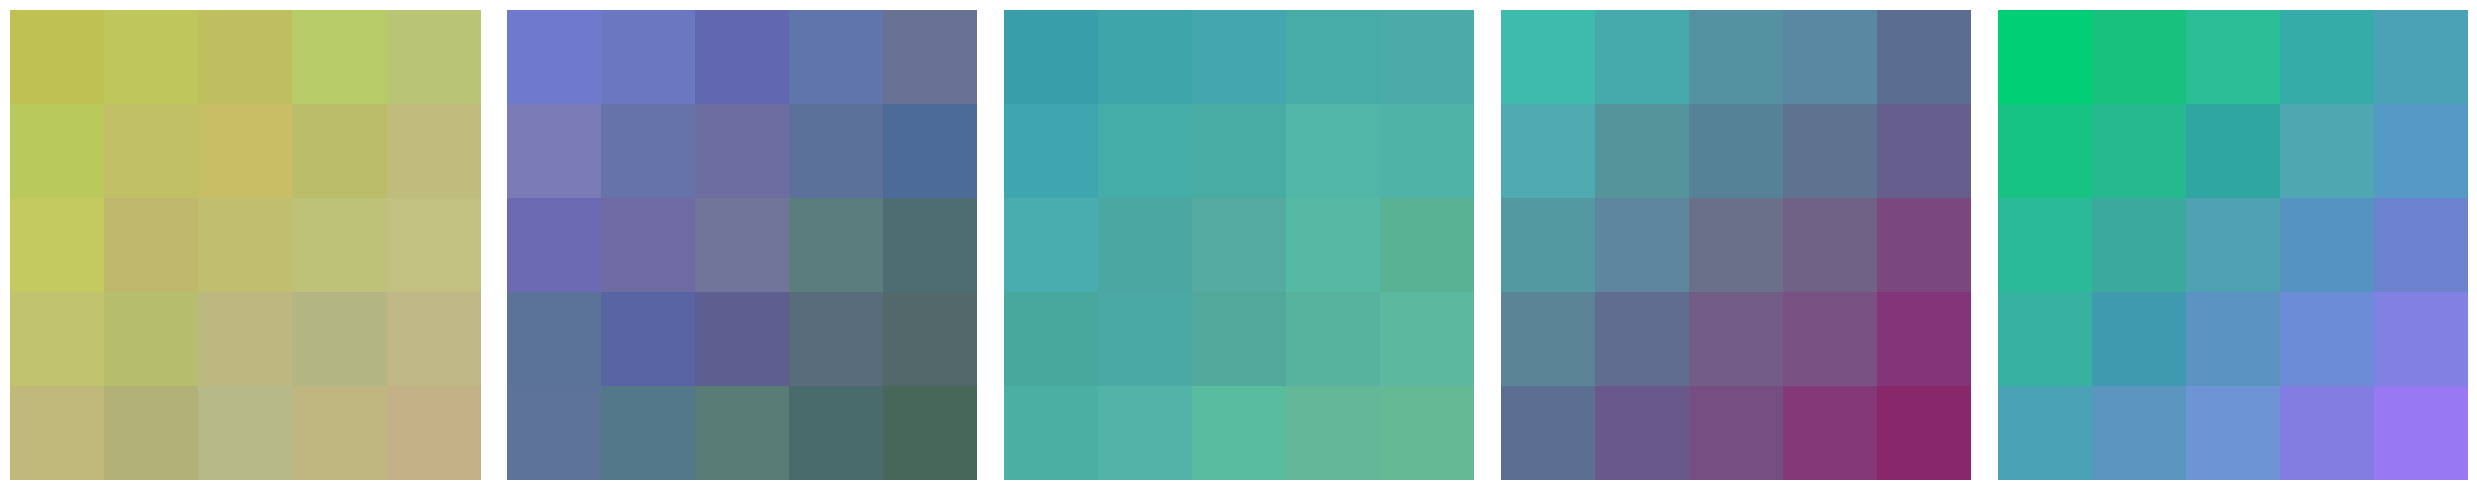

In [28]:
compiled_model = t.compile(model)
print("Generating images: ")
with t.inference_mode():
    samples = sample(compiled_model, 5)

images = [denormalize_img(s).cpu() for s in samples]
plot_images(t.stack(images))

Printing sequential denoising


100%|██████████| 100/100 [00:00<00:00, 11106.62it/s]


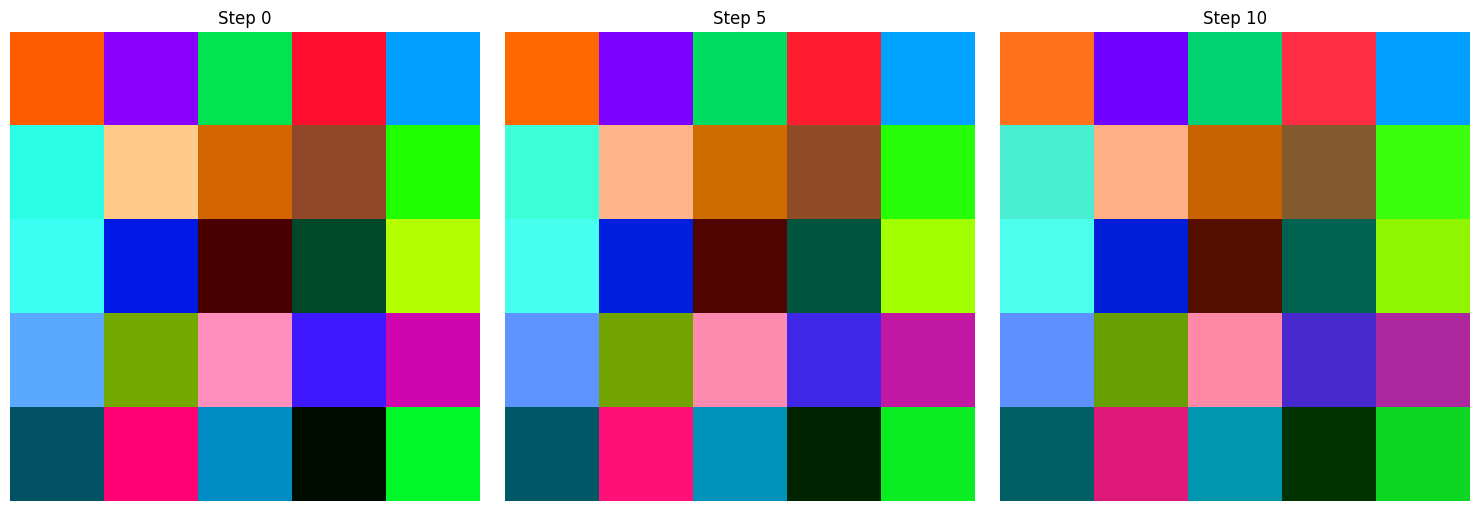

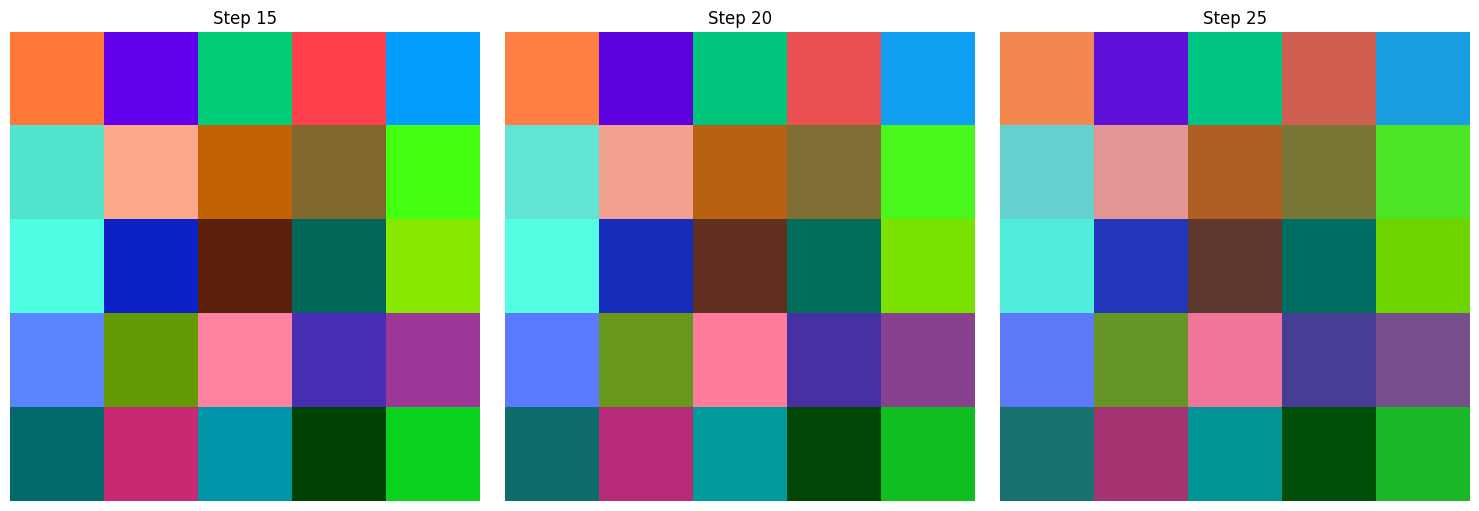

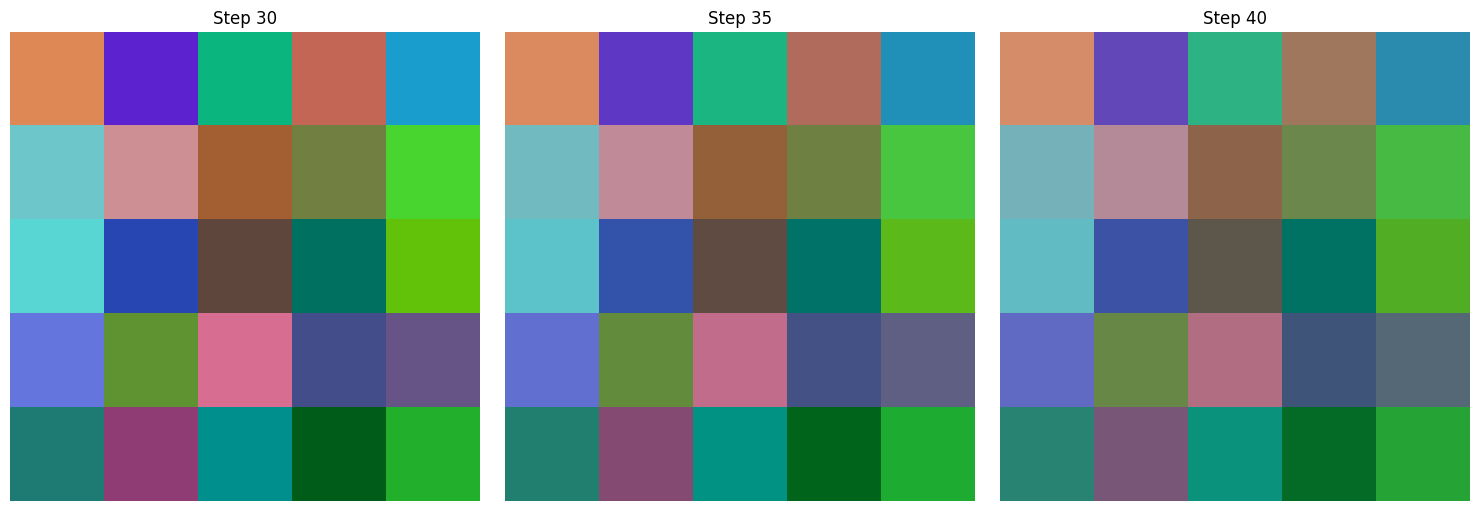

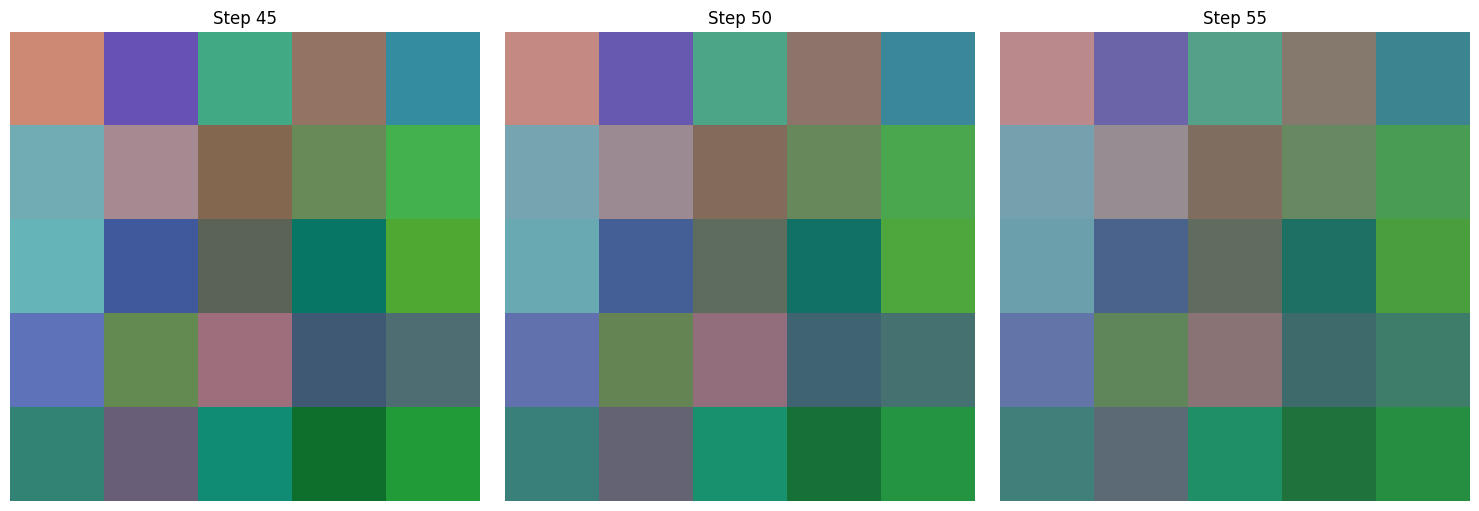

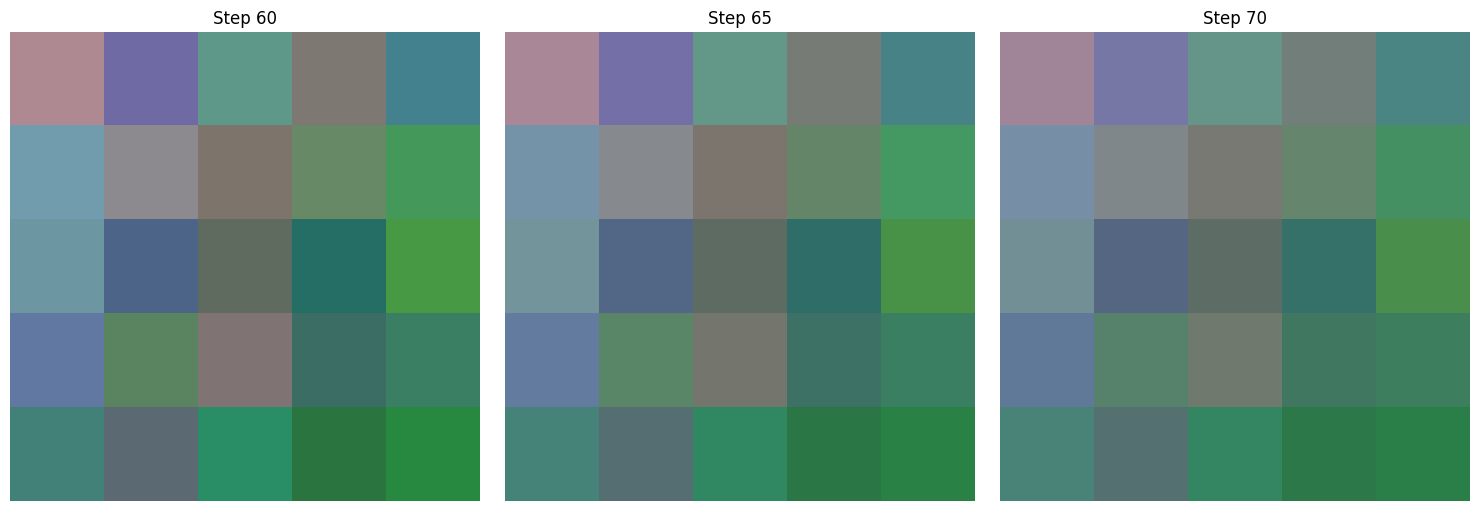

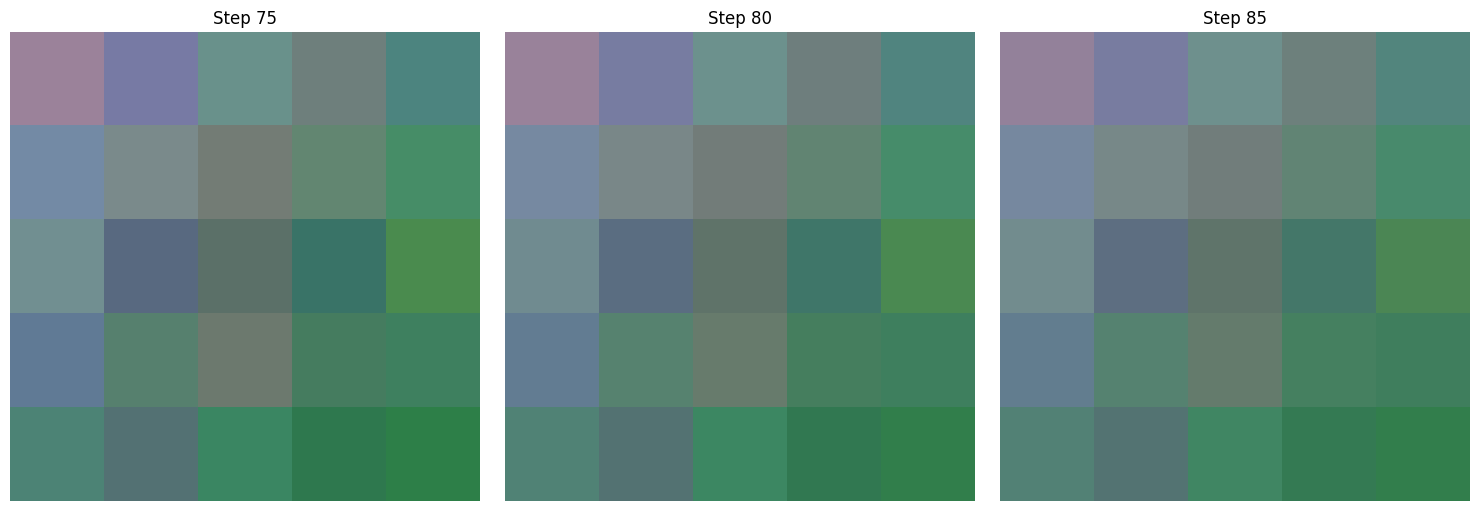

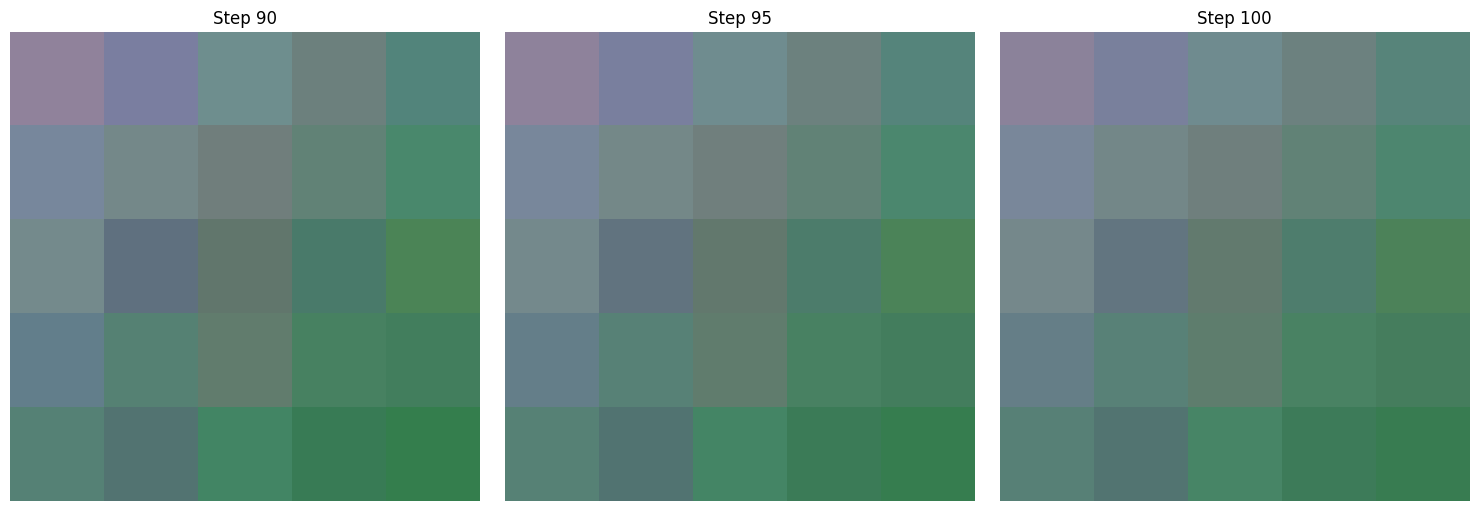

In [27]:
print("Printing sequential denoising")
with t.inference_mode():
    samples = sample(model, 1, return_all_steps=True)

images = []
titles = []
for i, s in enumerate(samples):
    if i % (len(samples) // 20) == 0:
        images.append(denormalize_img(s[0]))
        titles.append(f"Step {i}")

        if len(images) == 3:
            plot_images(t.stack(images), titles)    
            images = []
            titles = []